# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
con = sqlite3.connect(r"D:\AppliedAI\AAIC_Course_handouts\11_Amazon Fine Food Reviews\amazon-fine-food-reviews\database.sqlite")
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""",con)

# Change Score with 1 n 2 as -ve and 4 n 5 as +ve

def chng_to_0_or_1 (Score):
    if Score ==4 or Score ==5:
        return 1
    elif Score ==1 or Score ==2:
        return 0
    else:# Thus in case by some mistake any data is their with rating 6 or 7 etc due to some error is removed
        pass
currentScore = data["Score"]
new_Score = currentScore.map(chng_to_0_or_1)
data["Score"] = new_Score
print ("Number of data points available")
print (data.shape)#Gives original number of data points available


#2 Data Cleaning a.) Getting rid of duplicates and b.) if helpnessdenominator < helpfulnessnumerator


data = data.drop_duplicates(subset = ["UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary","Text"], keep='first', inplace=False)
print ("Number of data points after removing duplicates")
print (data.shape)#Gives data points are deduplication

# Reference: Copied from above cell  final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
print ("Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator ")
print (data.shape)

#3 Preprocessing begins

#Convert to lower case,convert shortcut words to proper words, remove Special Character

#i) Convert to lower case:
data["Text"] =  (data["Text"].str.lower())
data["Summary"] =  (data["Summary"].str.lower())

#ii) Convert Shortcuts words to proper words
#List of Words are:https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
#Reference:https://stackoverflow.com/questions/39602824/pandas-replace-string-with-another-string
data['Text'] = data['Text'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
##############Lets do the same for summary Text##################################
data['Summary'] = data['Summary'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
########################################################################################
# iii) Remove Special Characters except alpahbets and numbers
#The reason i dont want to remove number people might write got five eggs as 5 eggs or vice versa and dont want to lose 
#that information which could be useful
#Ref:https://stackoverflow.com/questions/33257344/how-to-remove-special-characers-from-a-column-of-dataframe-using-module-re
data["Text"]=data["Text"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))
data["Summary_copy"]=data["Summary"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))

#The Summary are usually so small if we remove few stopwords the meaning itself would be complely lost or chamge
# So let us see what all stopwords we have
#Ref:::::::::https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
#https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['would','could','br','<br>','<','>']
notstopwords = ['not','no','nor']
stopwords.extend(newStopWords)
stopwords = [word for word in stopwords if word not in notstopwords]

#  iv) For now let us just go with flow will use default stopwords as creating our own stop words is very time consuming
#Rather will use n-gram stratergy to get rid of problem of stopwords removal changing the meaning of sentences
#Ref:https://stackoverflow.com/questions/43184364/python-remove-stop-words-from-pandas-dataframe-give-wrong-output
data["New_Text"]= data['Text'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])
data["Summary"]= data['Summary_copy'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])

#Ref:https://stackoverflow.com/questions/37347725/converting-a-panda-df-list-into-a-string/37347837
#we are creating new column New_summary so in case in future we need summary it is intact
data["New_Text"]=data["New_Text"].apply(' '.join)
data["Summary"]=data["Summary"].apply(' '.join)

# v) Now lets do Stemming
#https://stackoverflow.com/questions/48617589/beginner-stemming-in-pandas-produces-letters-not-stems
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
data["New_Text"] = data["New_Text"].apply(english_stemmer.stem)
data["Summary"] = data["Summary"].apply(english_stemmer.stem)
data["New_Text"] = data["New_Text"].astype(str)
data["Summary"] = data["Summary"].astype(str)

#vi) stemming without removing stop words
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
#https://stackoverflow.com/questions/34724246/attributeerror-float-object-has-no-attribute-lower
data["Text_with_stop"]=data["Text"].astype(str)
data["Summary"]=data["Summary"].astype(str)
data["Text_with_stop"]=data["Text_with_stop"].str.lower().map(english_stemmer.stem)
data["Summary"]=data["Summary"].str.lower().map(english_stemmer.stem)
data["Text_with_stop"]=data["Text_with_stop"].apply(''.join)
data["Summary"]=data["Summary"].apply(''.join)
data["Text_with_stop"] = data["Text_with_stop"].astype(str)
data["Summary"] = data["Summary"].astype(str)
print(data["Score"].value_counts())
print ("Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced \
dataset we first copy negative dataset 6 times than we sample with same number of times as positive")
# Let include another feature which is the length of the text 
data_neg = data[data["Score"] == 0]
data_pos = data[data["Score"] == 1]
data = pd.concat([data_pos,data_neg])
#https://stackoverflow.com/questions/46429033/how-do-i-count-the-total-number-of-words-in-a-pandas-dataframe-cell-and-add-thos
data["Text_length"]= (data["New_Text"].str.count(' ') + 1)
data["Summary_length"]= (data["Summary"].str.count(' ') + 1)
data["Time_formatted"]= pd.to_datetime(data["Time"])
data.sort_values(by=['Time_formatted'], inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Number of data points available
(525814, 10)
Number of data points after removing duplicates
(366392, 10)
Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator 
(366390, 10)
1    308679
0     57711
Name: Score, dtype: int64
Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced dataset we first copy negative dataset 6 times than we sample with same number of times as positive


In [4]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

Y = data['Score'].values
X_no_stop = data['New_Text'].values
X_summary = data ['Summary'].values

X_no_stop_train, X_no_stop_test, y_train, y_test = train_test_split(X_no_stop, Y, test_size=0.33, shuffle=False)
X_no_stop_train, X_no_stop_CV, y_train, y_CV = train_test_split(X_no_stop_train, y_train, test_size=0.33, shuffle=False)

print ("The shape without stopwords of X Train, X CV, X Test, Y Train, Y CV and Y Test respectively are")
print(X_no_stop_train.shape, X_no_stop_CV.shape,X_no_stop_test.shape,y_train.shape,y_CV.shape,y_test.shape)

The shape without stopwords of X Train, X CV, X Test, Y Train, Y CV and Y Test respectively are
(164472,) (81009,) (120909,) (164472,) (81009,) (120909,)


In [5]:
X_summary_train,X_summary_test, y_summary_train, y_summary_test = train_test_split(X_summary, Y, test_size=0.33, shuffle=False)
X_summary_train,X_summary_CV, y_summary_train, y_summary_CV = train_test_split(X_summary_train,y_summary_train, test_size=0.33, shuffle=False)


## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import math

vectorizer = CountVectorizer()
bow_X_train_no_stop = vectorizer.fit_transform(X_no_stop_train)
bow_X_test_no_stop = vectorizer.transform(X_no_stop_test)
bow_X_CV_no_stop = vectorizer.transform(X_no_stop_CV)
##################     Summary    #####################################
bow_X_summary_train = vectorizer.fit_transform(X_summary_train)
bow_X_summary_test = vectorizer.transform(X_summary_test)
bow_X_summary_CV = vectorizer.transform(X_summary_CV)
####################################
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB

# creating odd list of alpha for BOW Naive bays
def tothepower(y):
    return (10**y)
alpha_NB_BOW = list(map(tothepower, list(range(-4, 5))))
print (alpha_NB_BOW)
alpha_NB_BOW_log = [math.log(x) for x in alpha_NB_BOW]
print (alpha_NB_BOW_log)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


In [7]:
auc_cv_no_stop = []
auc_train_no_stop=[]

for alpha in tqdm(alpha_NB_BOW):
    NB_BOW_no_stop = MultinomialNB(alpha=alpha)
    NB_BOW_no_stop.fit(bow_X_train_no_stop, y_train)
    proba_pred_train_BOW_no_stop=(NB_BOW_no_stop.predict_proba(bow_X_train_no_stop)[:,1])
    proba_pred_cv_BOW_no_stop=(NB_BOW_no_stop.predict_proba(bow_X_CV_no_stop)[:,1])
    auc_train_no_stop.append(roc_auc_score(y_train,proba_pred_train_BOW_no_stop))
    auc_cv_no_stop.append(roc_auc_score(y_CV,proba_pred_cv_BOW_no_stop))
    


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.13it/s]


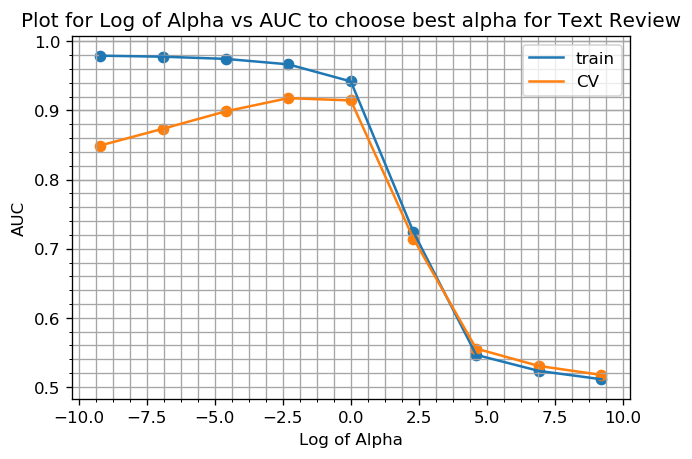

In [8]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.2
plt.plot(alpha_NB_BOW_log, auc_train_no_stop)
plt.scatter(alpha_NB_BOW_log, auc_train_no_stop)
plt.plot(alpha_NB_BOW_log, auc_cv_no_stop)
plt.scatter(alpha_NB_BOW_log, auc_cv_no_stop)
plt.xlabel('Log of Alpha')
plt.ylabel('AUC')
plt.title("Plot for Log of Alpha vs AUC to choose best alpha for Text Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

### We are performing the same on summary text review

In [9]:
auc_cv_summary = []
auc_train_summary=[]

for alpha in tqdm(alpha_NB_BOW):
    NB_BOW_summary = MultinomialNB(alpha=alpha)
    NB_BOW_summary.fit(bow_X_summary_train, y_summary_train)
    proba_pred_train_BOW_summary=(NB_BOW_summary.predict_proba(bow_X_summary_train)[:,1])
    proba_pred_cv_BOW_summary=(NB_BOW_summary.predict_proba(bow_X_summary_CV)[:,1])
    auc_train_summary.append(roc_auc_score(y_summary_train,proba_pred_train_BOW_summary))
    auc_cv_summary.append(roc_auc_score(y_summary_CV,proba_pred_cv_BOW_summary))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.46it/s]


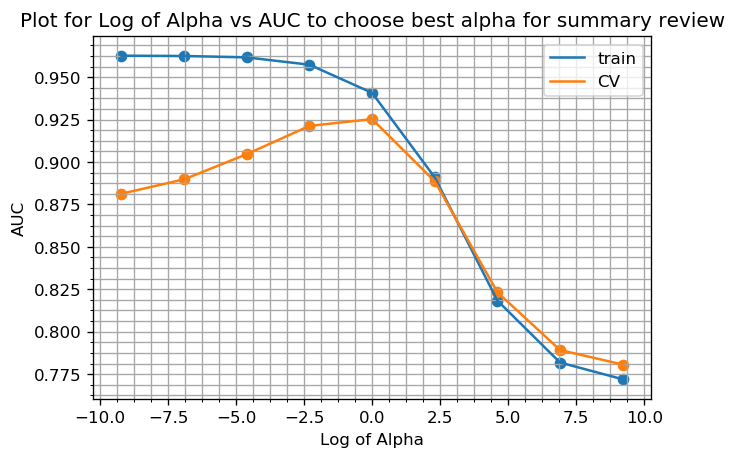

In [10]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.2
plt.plot(alpha_NB_BOW_log, auc_train_summary)
plt.scatter(alpha_NB_BOW_log, auc_train_summary)
plt.plot(alpha_NB_BOW_log, auc_cv_summary)
plt.scatter(alpha_NB_BOW_log, auc_cv_summary)
plt.xlabel('Log of Alpha')
plt.ylabel('AUC')
plt.title("Plot for Log of Alpha vs AUC to choose best alpha for summary review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

### So we can clearly observe best log of alpha lied somewhere between log of alpha of between -2.5 to 2.5 or alpha of .01 to 10. So let us now narrow down our search for best alpha between .01 to 10

In [11]:
import numpy as np
lis = np.arange (.01, 10, .25)
print (lis)

[0.01 0.26 0.51 0.76 1.01 1.26 1.51 1.76 2.01 2.26 2.51 2.76 3.01 3.26
 3.51 3.76 4.01 4.26 4.51 4.76 5.01 5.26 5.51 5.76 6.01 6.26 6.51 6.76
 7.01 7.26 7.51 7.76 8.01 8.26 8.51 8.76 9.01 9.26 9.51 9.76]


In [12]:
cv_auc = []
train_auc=[]

for alpha in tqdm(lis):
    NB_BOW = MultinomialNB(alpha=alpha)
    NB_BOW.fit(bow_X_train_no_stop, y_train)
    proba_pred_train_BOW=(NB_BOW.predict_proba(bow_X_train_no_stop)[:,1])
    proba_pred_cv_BOW=(NB_BOW.predict_proba(bow_X_CV_no_stop)[:,1])
    train_auc.append(roc_auc_score(y_train,proba_pred_train_BOW))
    cv_auc.append(roc_auc_score(y_CV,proba_pred_cv_BOW))


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.41it/s]


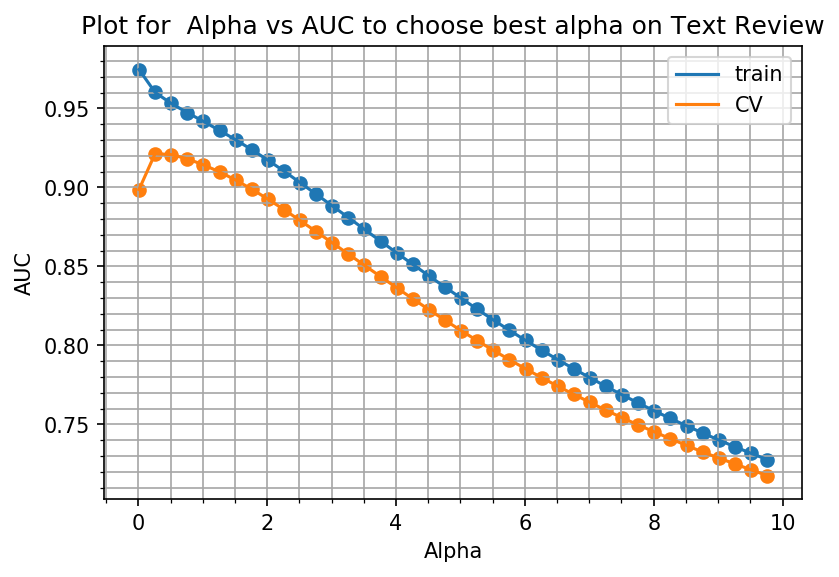

In [53]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(lis, train_auc)
plt.scatter(lis, train_auc)
plt.plot(lis, cv_auc )
plt.scatter(lis, cv_auc )
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.title("Plot for  Alpha vs AUC to choose best alpha on Text Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [14]:
cv_auc_sum = []
train_auc_sum=[]

for alpha in tqdm(lis):
    NB_BOW_summary = MultinomialNB(alpha=alpha)
    NB_BOW_summary.fit(bow_X_summary_train, y_summary_train)
    proba_pred_train_BOW_summary=(NB_BOW_summary.predict_proba(bow_X_summary_train)[:,1])
    proba_pred_cv_BOW_summary=(NB_BOW_summary.predict_proba(bow_X_summary_CV)[:,1])
    train_auc_sum.append(roc_auc_score(y_summary_train,proba_pred_train_BOW_summary))
    cv_auc_sum.append(roc_auc_score(y_summary_CV,proba_pred_cv_BOW_summary))


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.60it/s]


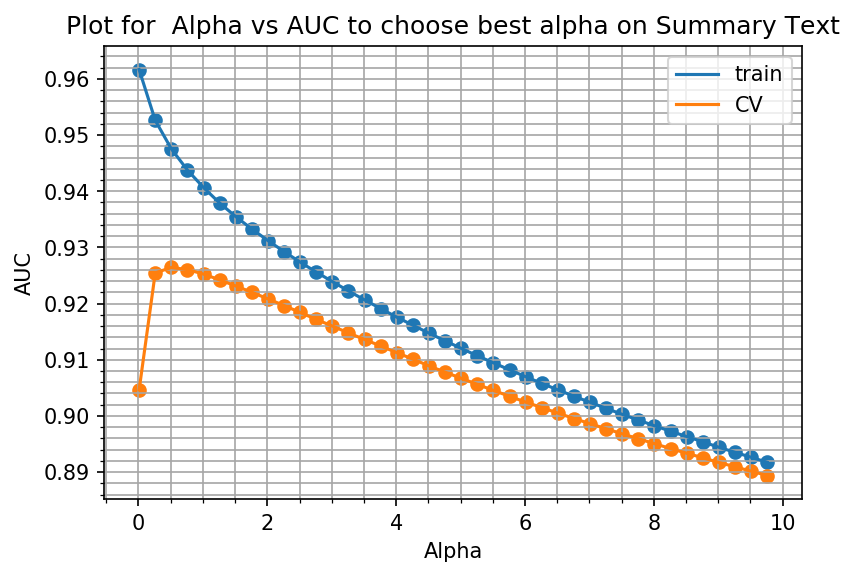

In [15]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(lis, train_auc_sum)
plt.scatter(lis, train_auc_sum)
plt.plot(lis, cv_auc_sum )
plt.scatter(lis, cv_auc_sum )
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.title("Plot for  Alpha vs AUC to choose best alpha on Summary Text")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

### So Best alpha both for Text and Summary is around ".3"

In [16]:
bestNB_BOW = MultinomialNB(alpha=.3)
bestNB_BOW.fit(bow_X_train_no_stop, y_train)
bestNB_proba_pred_train_BOW=(bestNB_BOW.predict_proba(bow_X_train_no_stop)[:,1])
bestNB_proba_pred_test_BOW=(bestNB_BOW.predict_proba(bow_X_test_no_stop)[:,1])

In [83]:
auc_test_BOW  = (roc_auc_score(y_test,bestNB_proba_pred_test_BOW))
auc_train_BOW  = (roc_auc_score(y_train,bestNB_proba_pred_train_BOW))


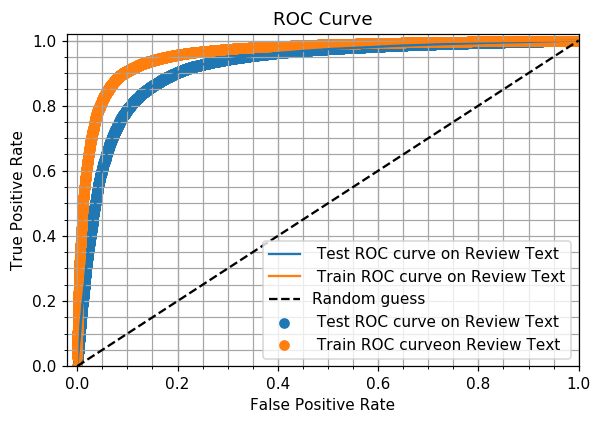

In [54]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_NB_bow_NS, tpr_test_NB_bow_NS, thresholds = roc_curve(y_test, bestNB_proba_pred_test_BOW)
fpr_train_NB_bow_NS, tpr_train_NB_bow_NS, thresholds = roc_curve(y_train, bestNB_proba_pred_train_BOW)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_NB_bow_NS, tpr_test_NB_bow_NS, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_NB_bow_NS, tpr_test_NB_bow_NS, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_NB_bow_NS, tpr_train_NB_bow_NS, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_NB_bow_NS, tpr_train_NB_bow_NS, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [55]:
bestNB_BOW = MultinomialNB(alpha=.3)
bestNB_BOW.fit(bow_X_train_no_stop, y_train)
bestNB_pred_train_BOW=bestNB_BOW.predict(bow_X_train_no_stop)
bestNB_pred_test_BOW=bestNB_BOW.predict(bow_X_test_no_stop)


In [56]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test, bestNB_pred_test_BOW))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, bestNB_pred_train_BOW))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.72      0.70      0.71     21261
          1       0.94      0.94      0.94     99648

avg / total       0.90      0.90      0.90    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.75      0.79      0.77     22681
          1       0.97      0.96      0.96    141791

avg / total       0.94      0.94      0.94    164472



IN NOT NORMALIZED FORMAT BELOW


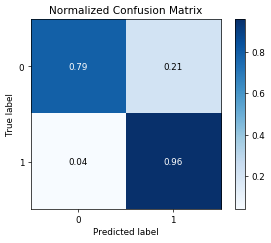

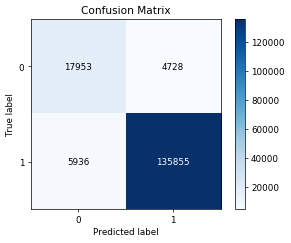

In [57]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt

plt.rcParams['figure.dpi'] = default_dpi*.63

skplt.plot_confusion_matrix(y_train,bestNB_pred_train_BOW,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")

skplt.plot_confusion_matrix(y_train,bestNB_pred_train_BOW)


IN NOT NORMALIZED FORMAT BELOW


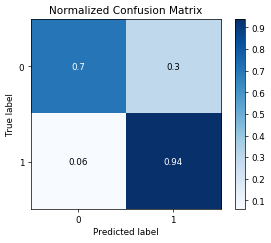

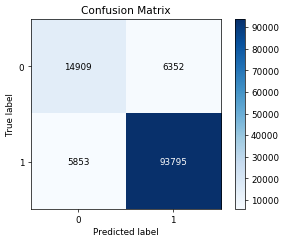

In [21]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63

skplt.plot_confusion_matrix(y_test, bestNB_pred_test_BOW,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_test, bestNB_pred_test_BOW)

### Reference:https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes



### Below is on for Summary Text

In [22]:
bestNB_BOW_sum = MultinomialNB(alpha=.3)
bestNB_BOW_sum.fit(bow_X_summary_train, y_summary_train)
bestNB_proba_pred_train_BOW_sum=(bestNB_BOW_sum.predict_proba(bow_X_summary_train)[:,1])
bestNB_proba_pred_test_BOW_sum=(bestNB_BOW_sum.predict_proba(bow_X_summary_test)[:,1])

In [84]:
auc_train_bow_sum = (roc_auc_score(y_summary_train,bestNB_proba_pred_train_BOW_sum))
auc_test_bow_sum = (roc_auc_score(y_summary_test,bestNB_proba_pred_test_BOW_sum))

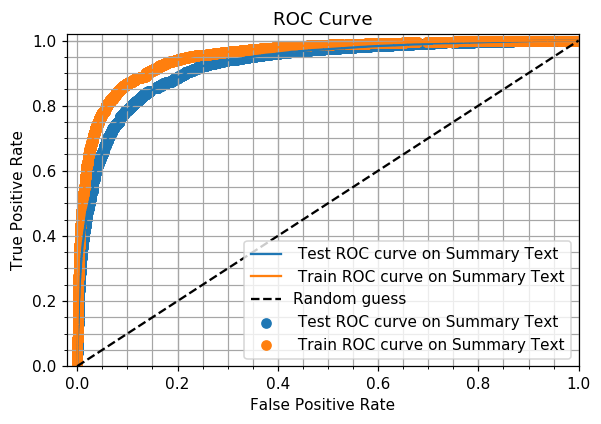

In [23]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_NB_bow_NS_sum, tpr_test_NB_bow_NS_sum, thresholds = roc_curve(y_summary_test, bestNB_proba_pred_test_BOW_sum)
fpr_train_NB_bow_NS_sum, tpr_train_NB_bow_NS_sum, thresholds = roc_curve(y_summary_train, bestNB_proba_pred_train_BOW_sum)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_NB_bow_NS_sum, tpr_test_NB_bow_NS_sum, label=' Test ROC curve on Summary Text')
plt.scatter(fpr_test_NB_bow_NS_sum, tpr_test_NB_bow_NS_sum, label=' Test ROC curve on Summary Text')
plt.plot(fpr_train_NB_bow_NS_sum, tpr_train_NB_bow_NS_sum, label=' Train ROC curve on Summary Text')
plt.scatter(fpr_train_NB_bow_NS_sum, tpr_train_NB_bow_NS_sum, label=' Train ROC curve on Summary Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [24]:
bestNB_BOW_sum = MultinomialNB(alpha=.3)
bestNB_BOW_sum.fit(bow_X_summary_train, y_summary_train)
bestNB_pred_train_BOW_sum=bestNB_BOW_sum.predict(bow_X_summary_train)
bestNB_pred_test_BOW_sum=bestNB_BOW_sum.predict(bow_X_summary_test)


In [58]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset for Summary Text")
print ("#######################################################")

print(classification_report(y_summary_test, bestNB_pred_test_BOW_sum))


print ("#######################################################")
print ("The classification report on Training dataset For Summary Text")
print ("#######################################################")
print(classification_report(y_summary_train, bestNB_pred_train_BOW_sum))

#######################################################
The classification report on Test dataset for Summary Text
#######################################################
             precision    recall  f1-score   support

          0       0.76      0.60      0.67     21261
          1       0.92      0.96      0.94     99648

avg / total       0.89      0.90      0.89    120909

#######################################################
The classification report on Training dataset For Summary Text
#######################################################
             precision    recall  f1-score   support

          0       0.78      0.67      0.72     22681
          1       0.95      0.97      0.96    141791

avg / total       0.93      0.93      0.93    164472



IN NOT NORMALIZED FORMAT BELOW


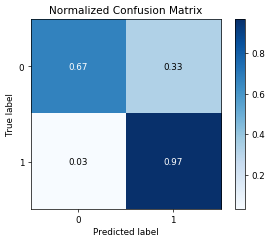

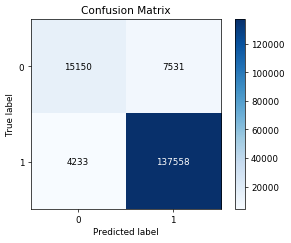

In [26]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt

plt.rcParams['figure.dpi'] = default_dpi*.63

skplt.plot_confusion_matrix(y_summary_train, bestNB_pred_train_BOW_sum,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")

skplt.plot_confusion_matrix(y_summary_train, bestNB_pred_train_BOW_sum)


IN NOT NORMALIZED FORMAT BELOW


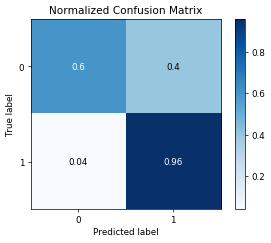

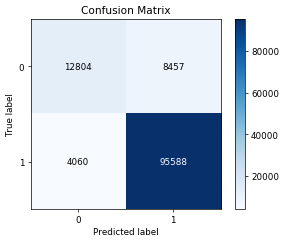

In [27]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt

plt.rcParams['figure.dpi'] = default_dpi*.63

skplt.plot_confusion_matrix(y_summary_test, bestNB_pred_test_BOW_sum,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")

skplt.plot_confusion_matrix(y_summary_test, bestNB_pred_test_BOW_sum)

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [28]:
bestNB_BOW_sum = MultinomialNB(alpha=.5)
bestNB_BOW_sum.fit(bow_X_summary_train, y_summary_train)
feature_log_prob_ =bestNB_BOW_sum.feature_log_prob_
bow_features_name = vectorizer.get_feature_names()
feature_prob = pd.DataFrame(feature_log_prob_, columns = bow_features_name)
feature_prob_tr = feature_prob.T
feature_count =bestNB_BOW_sum.feature_count_
count = pd.DataFrame(feature_count, columns = bow_features_name)
count_tr = count.T

In [29]:
print("\n\n Top 10 positive features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])
print ("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print ("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print ("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

print ("The count for number of times top most 100 words was used for positive reviews")
print (count_tr[1].sort_values(ascending = False)[0:100])



 Top 10 positive features:-
 great       -2.983125
good        -3.474666
best        -3.584458
tea         -4.084955
love        -4.316402
product     -4.401193
excellent   -4.732411
coff        -4.884914
flavor      -4.895109
delici      -4.904781
Name: 1, dtype: float64
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
The count for number of times top most 100 words was used for positive reviews
great        21791.0
good         13329.0
best         11943.0
tea           7240.0
love          5744.0
product       5277.0
excellent     3789.0
coff          3253.0
flavor        3220.0
delici        3189.0
not           3083.0
lov           3043.0
delicious     2764.0
food          2651.0
dog           2568.0
ev            2563.0
stuff         2528.0
snack         2436.

### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [30]:
print("Top 10 negative features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print ("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print ("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print ("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print ("The count for number of times top most 100 words was used for negative reviews")
print (count_tr[0].sort_values(ascending = False)[0:100])

Top 10 negative features:-
 not          -2.943071
good         -4.290391
like         -4.584330
product      -4.712191
flavor       -4.842844
taste        -4.871808
disappoint   -4.875079
no           -4.888269
bad          -4.922028
great        -4.923746
Name: 0, dtype: float64
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
The count for number of times top most 100 words was used for negative reviews
not           4214.0
good          1095.0
like           816.0
product        718.0
flavor         630.0
taste          612.0
disappoint     610.0
no             602.0
bad            582.0
great          581.0
tast           579.0
dont           541.0
buy            451.0
tastes         427.0
tea            412.0
yuck           309.0
much           308.0
poor        

### Examples Feature Engineering. 

1)  The above experiment that we did on text can we do it on summary i.e which word/feature is used most for positive or negative review summary. The reason being in long text we tend to write general works like "product","taste","flavour" which is most used words both for positive and negative review (asked in homework/assignment)

2) Length of text (asked in homework/assignment)

3) Product with highest helpfullness are they sold more compared to lower helpfullness product

4) Does length of text anything to do with helpfullness

5) Does length of text anything to do amount of product sold (score as we dont have data on amount of data sold so lets just take product sold more should have been given good rating)

6) Has number of reviews either good or bad anything to do with amount of product sold

7) UserID who has purchased maximum product do they write summary 

8) UserID who has purchased maximum product do they mark text as helpful or not

9) UserID who has purchased maximum product do they read lengthy reviews or shorter reviews



### In this assignment lets take up 1) 2)  3) 4) and 5

In [31]:
# 1)  The above experiment that we did on text can we do it on summary i.e which word/feature is used most 
#for positive or negative review summary. The reason being in long text we tend to write general works
#like "product","taste","flavour" which is most used words both for positive and negative 
#review (asked in homework/assignment)



In [32]:
# 2) and  4) Any Relation b/w length of Text/Summary and Helpfullness?

import matplotlib.pyplot as plt
%matplotlib inline
#print (data)
lst_len_txt =data["Text_length"].tolist()
lst_len_sum =data["Summary_length"].tolist()
lst_helpfulness = data["HelpfulnessNumerator"].tolist()


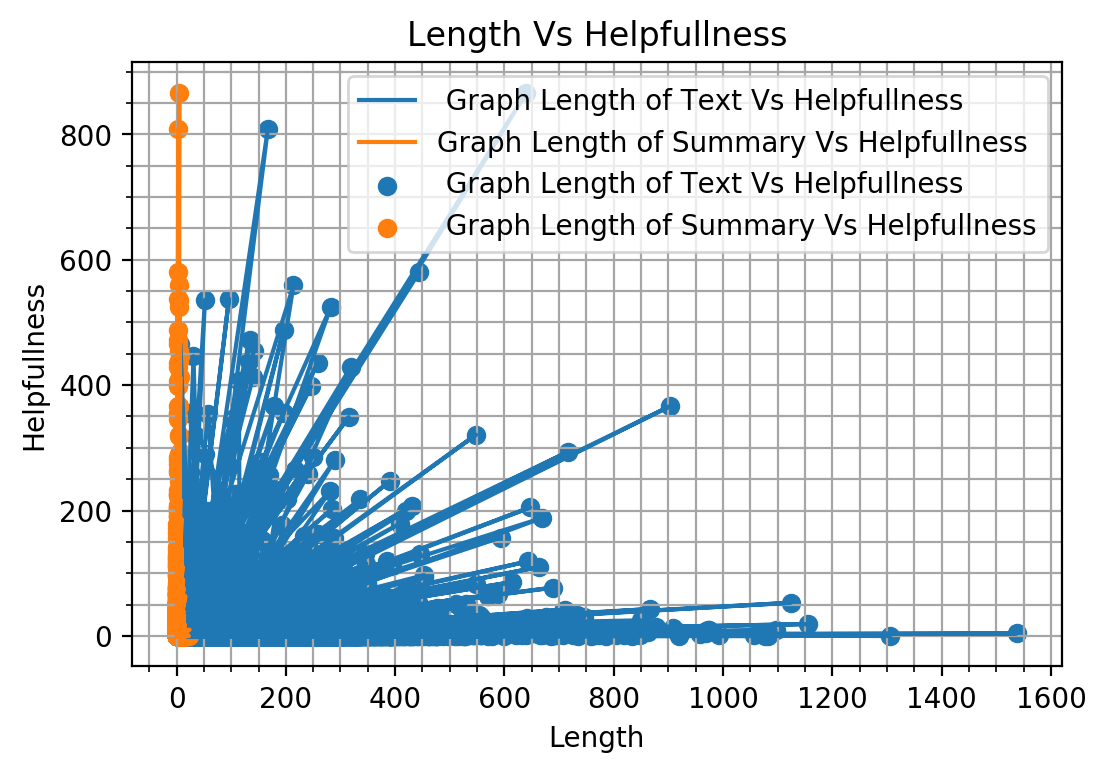

In [33]:
# create plot
plt.rcParams['figure.dpi'] = default_dpi*2
plt.plot(lst_len_txt, lst_helpfulness, label=' Graph Length of Text Vs Helpfullness')
plt.scatter(lst_len_txt, lst_helpfulness, label=' Graph Length of Text Vs Helpfullness')
plt.plot(lst_len_sum, lst_helpfulness, label='Graph Length of Summary Vs Helpfullness')
plt.scatter(lst_len_sum, lst_helpfulness, label=' Graph Length of Summary Vs Helpfullness')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('Length')
_ = plt.ylabel('Helpfullness')
_ = plt.title('Length Vs Helpfullness')
_ = plt.legend(loc="upper right")

In [34]:
# Any relationship b/w Product with higher helpfullness and number of items sold (rating score)

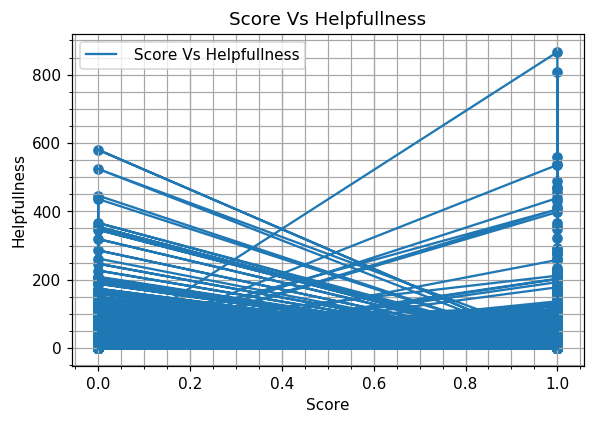

In [43]:
# create plot
lst_score = data["Score"].tolist()
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(lst_score, lst_helpfulness, label=' Score Vs Helpfullness')
plt.scatter(lst_score, lst_helpfulness)
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('Score')
_ = plt.ylabel('Helpfullness')
_ = plt.title('Score Vs Helpfullness')
_ = plt.legend(loc="upper left")

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,5))
tfidf_X_train = tf_idf_vect.fit_transform(X_no_stop_train)
tfidf_X_test = tf_idf_vect.transform(X_no_stop_test)
tfidf_X_CV = tf_idf_vect.transform(X_no_stop_CV)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


In [60]:
# creating odd list of alpha for  Naive bays
def tothepower(y):
    return (10**y)
alpha_NB = list(map(tothepower, list(range(-4, 5))))
print (alpha_NB)
alpha_NB_log = [math.log(x) for x in alpha_NB]
print (alpha_NB_log)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


In [61]:
auc_cv_tfidf = []
auc_train_tfidf=[]

for alpha in tqdm(alpha_NB):
    NB_tfidf = MultinomialNB(alpha=alpha)
    NB_tfidf.fit(tfidf_X_train, y_train)
    proba_pred_train_tfidf=(NB_tfidf.predict_proba(tfidf_X_train)[:,1])
    proba_pred_cv_tfidf=(NB_tfidf.predict_proba(tfidf_X_CV)[:,1])
    auc_train_tfidf.append(roc_auc_score(y_train,proba_pred_train_tfidf))
    auc_cv_tfidf.append(roc_auc_score(y_CV,proba_pred_cv_tfidf))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:21<00:00,  2.38s/it]


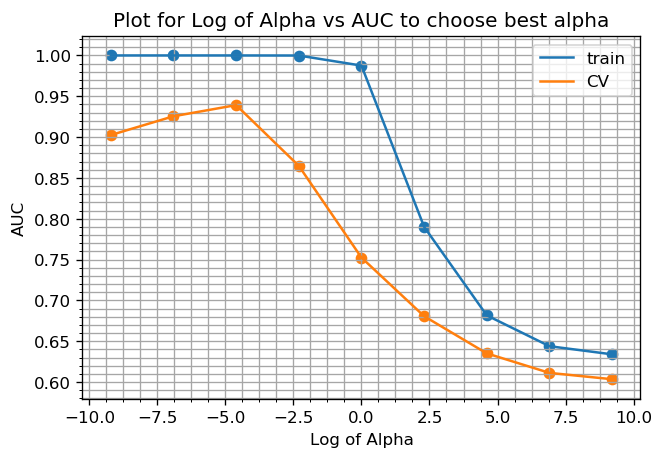

In [62]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.2
plt.plot(alpha_NB_log, auc_train_tfidf)
plt.scatter(alpha_NB_log, auc_train_tfidf)
plt.plot(alpha_NB_log, auc_cv_tfidf)
plt.scatter(alpha_NB_log, auc_cv_tfidf)
plt.xlabel('Log of Alpha')
plt.ylabel('AUC')
plt.title("Plot for Log of Alpha vs AUC to choose best alpha")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [65]:
import numpy as np
lis_n = np.arange (.001, .1, .005)
auc_cv_tfidf = []
auc_train_tfidf=[]

for alpha in tqdm(lis_n):
    NB_tfidf = MultinomialNB(alpha=alpha)
    NB_tfidf.fit(tfidf_X_train, y_train)
    proba_pred_train_tfidf=(NB_tfidf.predict_proba(tfidf_X_train)[:,1])
    proba_pred_cv_tfidf=(NB_tfidf.predict_proba(tfidf_X_CV)[:,1])
    auc_train_tfidf.append(roc_auc_score(y_train,proba_pred_train_tfidf))
    auc_cv_tfidf.append(roc_auc_score(y_CV,proba_pred_cv_tfidf))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.30s/it]


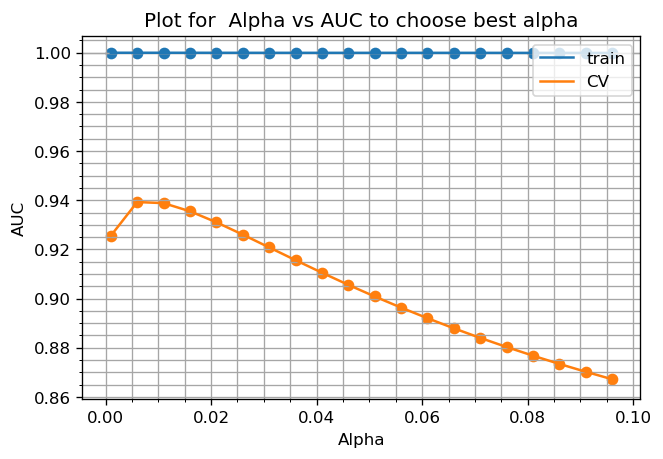

In [66]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.2
plt.plot(lis_n, auc_train_tfidf)
plt.scatter(lis_n, auc_train_tfidf)
plt.plot(lis_n, auc_cv_tfidf)
plt.scatter(lis_n, auc_cv_tfidf)
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.title("Plot for  Alpha vs AUC to choose best alpha")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [68]:
bestNB_tfidf = MultinomialNB(alpha=.01)
bestNB_tfidf.fit(tfidf_X_train, y_train)
bestNB_proba_pred_train_tfidf=(bestNB_tfidf.predict_proba(tfidf_X_train)[:,1])
bestNB_proba_pred_test_tfidf=(bestNB_tfidf.predict_proba(tfidf_X_test)[:,1])

In [85]:
auc_test_BOW_tfidf  = (roc_auc_score(y_test,bestNB_proba_pred_test_tfidf))
auc_train_BOW_tfidf  = (roc_auc_score(y_train,bestNB_proba_pred_train_tfidf))


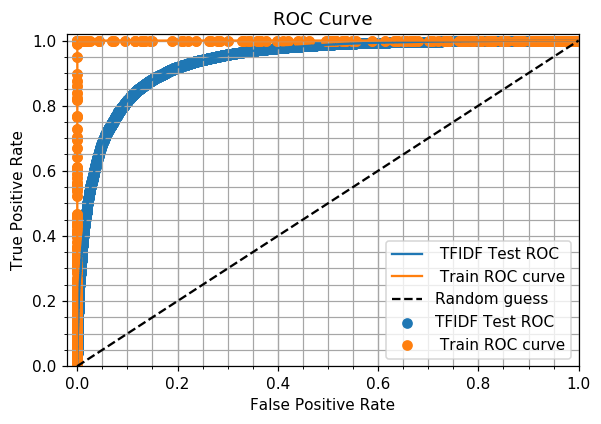

In [69]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_NB_tfidf, tpr_test_NB_tfidf, thresholds = roc_curve(y_test, bestNB_proba_pred_test_tfidf)
fpr_train_NB_tfidf, tpr_train_NB_tfidf, thresholds = roc_curve(y_train, bestNB_proba_pred_train_tfidf)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_NB_tfidf, tpr_test_NB_tfidf, label=' TFIDF Test ROC ')
plt.scatter(fpr_test_NB_tfidf, tpr_test_NB_tfidf, label='TFIDF Test ROC ')
plt.plot(fpr_train_NB_tfidf, tpr_train_NB_tfidf, label=' Train ROC curve')
plt.scatter(fpr_train_NB_tfidf, tpr_train_NB_tfidf, label=' Train ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [70]:
bestNB_tfidf = MultinomialNB(alpha=.01)
bestNB_tfidf.fit(tfidf_X_train, y_train)
bestNB_pred_train_tfidf=bestNB_tfidf.predict(tfidf_X_train)
bestNB_pred_test_tfidf=bestNB_tfidf.predict(tfidf_X_test)

In [71]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset")
print ("#######################################################")

print(classification_report(y_test, bestNB_pred_test_tfidf))


print ("#######################################################")
print ("The classification report on Training dataset")
print ("#######################################################")
print(classification_report(y_train, bestNB_pred_train_tfidf))



#######################################################
The classification report on Test dataset
#######################################################
             precision    recall  f1-score   support

          0       0.95      0.29      0.44     21261
          1       0.87      1.00      0.93     99648

avg / total       0.88      0.87      0.84    120909

#######################################################
The classification report on Training dataset
#######################################################
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     22681
          1       1.00      1.00      1.00    141791

avg / total       1.00      1.00      1.00    164472



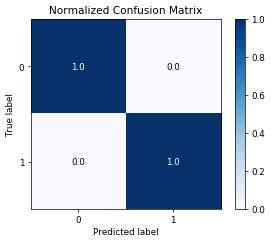

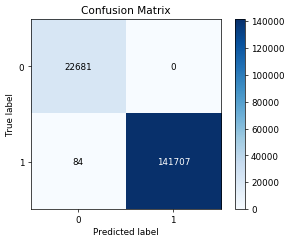

In [72]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt

plt.rcParams['figure.dpi'] = default_dpi*.63

skplt.plot_confusion_matrix(y_train,bestNB_pred_train_tfidf,normalize=True)
skplt.plot_confusion_matrix(y_train,bestNB_pred_train_tfidf)

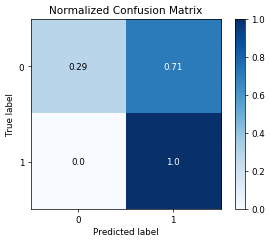

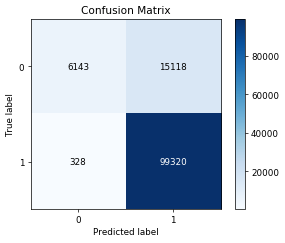

In [73]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt

plt.rcParams['figure.dpi'] = default_dpi*.63

skplt.plot_confusion_matrix(y_test,bestNB_pred_test_tfidf,normalize=True)
skplt.plot_confusion_matrix(y_test,bestNB_pred_test_tfidf)

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

### Reference::https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes

In [74]:
bestNB_tfidf_NS = MultinomialNB(alpha=.01)
bestNB_tfidf_NS.fit(tfidf_X_train, y_train)
feature_log_prob_ =bestNB_tfidf_NS.feature_log_prob_ #https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
features_name_tfidf = tf_idf_vect.get_feature_names() #https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
feature_prob = pd.DataFrame(feature_log_prob_, columns = features_name_tfidf) #https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
feature_prob_tr = feature_prob.T


In [75]:
print("\n\n Top 10 positive features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])



 Top 10 positive features:-
 great     -7.607158
tea       -7.673285
good      -7.681102
not       -7.695874
like      -7.756590
coffee    -7.879960
love      -7.916423
product   -7.950869
taste     -7.997868
flavor    -7.998985
Name: 1, dtype: float64


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [76]:
print("\n\n Top 10 Negative features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])



 Top 10 Negative features:-
 not       -7.426898
like      -7.958729
product   -8.037271
taste     -8.097037
one       -8.367449
coffee    -8.379036
no        -8.473495
flavor    -8.485542
buy       -8.562469
tea       -8.565086
Name: 0, dtype: float64


### Feature Engineering

In [78]:
# Count of top 100 Words for both positive and negative reviews
feature_count =bestNB_tfidf_NS.feature_count_
count = pd.DataFrame(feature_count, columns = features_name_tfidf)
count_tr = count.T
print ("Count of Words for negative reviews")
print (count_tr[0].sort_values(ascending = False)[0:100])
print ("Count of Words for Positive reviews")
print (count_tr[1].sort_values(ascending = False)[0:100])

Count of Words for negative reviews
not             284.137962
like            166.934784
product         154.324459
taste           145.370604
one             110.924961
coffee          109.646939
no               99.763024
flavor           98.568221
buy              91.269224
tea              91.030678
good             90.236301
dont             90.057372
even             80.988011
get              76.511419
much             75.046505
box              74.830627
bad              73.871990
food             73.570499
bought           72.451484
amazon           71.545461
really           68.556866
didnt            63.280645
chocolate        63.262264
tried            63.109487
money            62.651015
im               62.283978
ordered          61.061429
disappointed     59.357593
thought          59.029021
tastes           57.305854
                   ...    
still            40.384549
reviews          39.987852
want             39.694172
doesnt           39.588886
find             39

# [6] Conclusions

In [87]:
# Prettytable for alpha,AUC,Precision,recall and Accuracy

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Algorithm","Parameter alpha","AUC"]

x.add_row(["BOW Naive Bayes Review Text Train Data", .3, auc_train_BOW])
x.add_row(["BOW Naive Bayes Review Text Test Data", .3, auc_test_BOW])
x.add_row(["BOW Naive Bayes Summary Text Train Data", .3, auc_train_bow_sum])
x.add_row(["BOW Naive Bayes Summary Text Test Data", .3, auc_test_bow_sum])
x.add_row(["TFIDF Naive Bayes Review Text Train Data", .01, auc_train_BOW_tfidf])
x.add_row(["TFIDF Naive Bayes Review Text Test Data", .01, auc_test_BOW_tfidf])
print(x)

+------------------------------------------+-----------------+--------------------+
|                Algorithm                 | Parameter alpha |        AUC         |
+------------------------------------------+-----------------+--------------------+
|  BOW Naive Bayes Review Text Train Data  |       0.3       | 0.9588422862145487 |
|  BOW Naive Bayes Review Text Test Data   |       0.3       | 0.9178479285606571 |
| BOW Naive Bayes Summary Text Train Data  |       0.3       | 0.951624035695791  |
|  BOW Naive Bayes Summary Text Test Data  |       0.3       | 0.9234990787816754 |
| TFIDF Naive Bayes Review Text Train Data |       0.01      | 0.9999905009750969 |
| TFIDF Naive Bayes Review Text Test Data  |       0.01      | 0.9371502082230916 |
+------------------------------------------+-----------------+--------------------+


### So we observe for both the algorithms Naive bayes performs lot better compared to KNN and takes lotlesser time as well.
### Out of these two (i.e BOW and TFIDF using Naive Bayes we see BOW performs much better as recall value for TFIDF is poor)